# Create Session Report

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from collections import Counter

import numpy as np

from convnwb.io import load_nwbfile

from spiketools.measures import compute_firing_rate
from spiketools.spatial.occupancy import compute_occupancy

from spiketools.plts.data import plot_bar, plot_hist, plot_polar_hist, plot_text
from spiketools.plts.spatial import plot_heatmap, plot_positions
from spiketools.plts.spikes import plot_firing_rates
from spiketools.plts.utils import make_grid, get_grid_subplot
from spiketools.utils.epoch import epoch_data_by_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from reports import (create_subject_info, create_subject_str, create_position_str,
                     create_behav_info, create_behav_str)

## Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/NWB')

In [6]:
# Define subject information
session = {
    'task' : 'THF',
    'subject' : 'wv001',
    'session' : 2
}

In [7]:
# Define bins to use
bins = [9, 12]

# Define minimum occupancy
min_occ = 1

## Load Data

In [8]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

### Epoch Information

In [9]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

### Position Information

In [10]:
# Get area ranges, adding a buffer to the z-range (for tower transport)
area_range = [nwbfile.acquisition['boundaries']['x_range'].data[:],
              nwbfile.acquisition['boundaries']['z_range'].data[:] + np.array([-10, 10])]

In [11]:
# Get position, speed and head direction information
positions = nwbfile.acquisition['position']['player_position'].data[:].T
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

# Get head directions
hd_degrees = nwbfile.acquisition['heading']['direction'].data[:]

# Get chest positions
chest_positions = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T

In [12]:
# Get position data for navigation segments
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

# Recombine position data across selected navigation trials
ptimes = np.hstack(ptimes_trials)
positions = np.hstack(positions_trials)
stimes = np.hstack(stimes_trials)
speed = np.hstack(speed_trials)

### Occupancy

In [13]:
# Compute occupancy
occ = compute_occupancy(positions, ptimes, bins,
                        speed, minimum=min_occ,
                        area_range=area_range, set_nan=True)

## Behavioural Information

In [14]:
# Count confidence answers
conf_counts = Counter(nwbfile.trials.confidence_response.data[:])

In [15]:
# Fix confidence answers
for el in ['yes', 'maybe', 'no']:
    if el not in conf_counts:
        conf_counts[el] = 0

## Unit Information

In [16]:
# Get unit information
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)

In [17]:
# Compute firing rates for all units marked to keep
frs = [compute_firing_rate(nwbfile.units.get_unit_spike_times(uind)) \
       for uind in keep_inds]

## Create Report

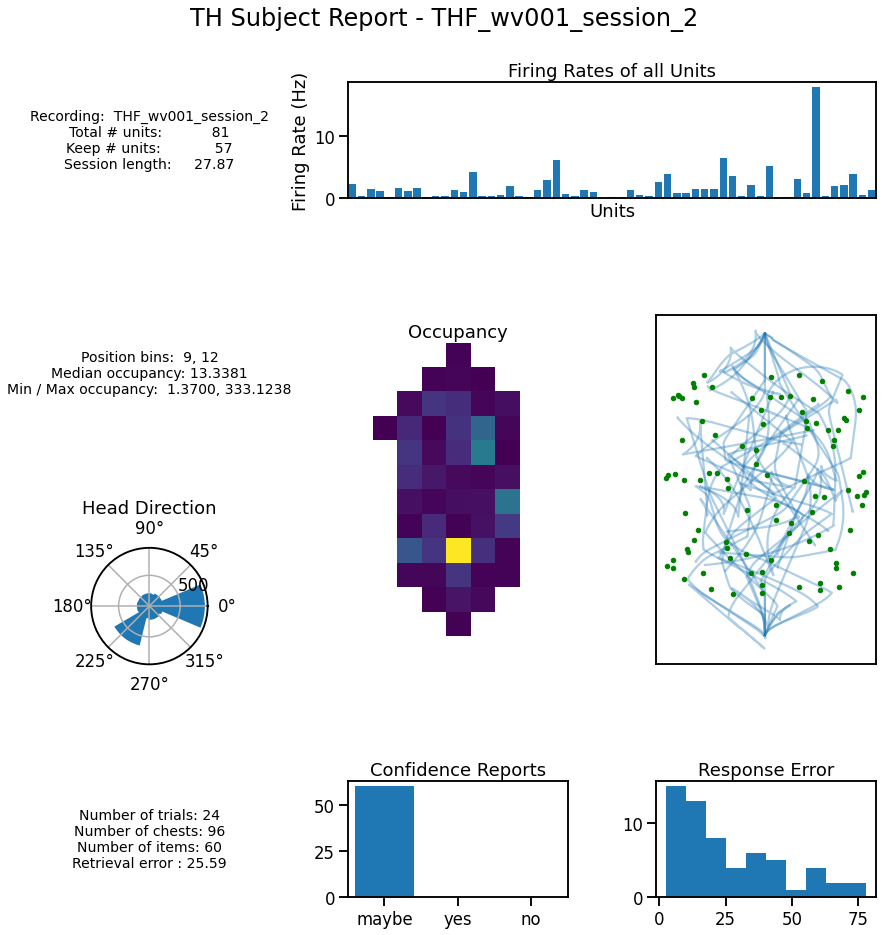

In [18]:
# Initialize figure with grid layout
grid = make_grid(4, 3, wspace=0.4, hspace=1.0, figsize=(15, 15),
                 title='TH Subject Report - {}'.format(nwbfile.session_id))

# 00: subject text
plot_text(create_subject_str(create_subject_info(nwbfile)), ax=get_grid_subplot(grid, 0, 0))

# 01: neuron fig
plot_firing_rates(frs, xticks=[], ax=get_grid_subplot(grid, 0, slice(1, None)))

# 10: position text
plot_text(create_position_str(bins, occ), ax=get_grid_subplot(grid, 1, 0))

# 11: occupancy map
plot_heatmap(occ, title='Occupancy', ax=get_grid_subplot(grid, slice(1, 3), 1))

# 12: subject positions overlaid with chest positions
plot_positions(positions_trials, landmarks={'positions' : chest_positions, 'color' : 'green'},
               ax=get_grid_subplot(grid, slice(1, 3), 2))

# 20: head direction
plot_polar_hist(hd_degrees, title='Head Direction', ax=get_grid_subplot(grid, 2, 0, polar=True))

# 30: behaviour text
plot_text(create_behav_str(create_behav_info(nwbfile)), ax=get_grid_subplot(grid, 3, 0))

# 31: choice point plot
plot_bar(conf_counts.values(), conf_counts.keys(),
         title='Confidence Reports', ax=get_grid_subplot(grid, 3, 1))

# 32: errors plot
plot_hist(nwbfile.trials.error.data[:], title='Response Error', ax=get_grid_subplot(grid, 3, 2))